# Homework 6 - Datasets


## Exercise 1

Objective:
Implement a dataset class for the custom dataset: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection

Note, that this dataset contains object detection annotations in the form of xml files. Object detection annotations are a way to describe the location (bounding box) in addition to the class of objects in an image.

The task is to:

1. Download the dataset locally
2. Pass the path to the test folder to the `root_dir` parameter of the `CustomDataset` constructor method.
3. Complete the methods of the `CustomDataset` class, so that it can be used to load the data.
4. Introduce all the sensible transformations to the dataset, including four new transformations that were not used during the lecture. Feel free to use `albumentations` or `torchvision.transforms.v2`. Try to apply point transformations to images, such that the
labels remain valid after transformation has been applied.

Hint: To read the xml files, you can use the `xml.etree.ElementTree` module.

```

/home/hodor/Projects/laba_cv_homeworks/venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


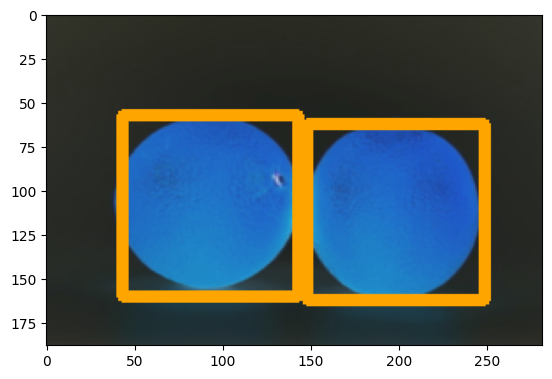

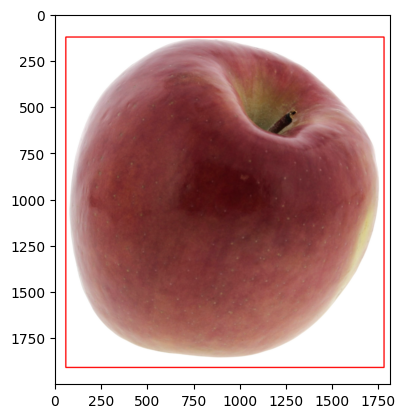

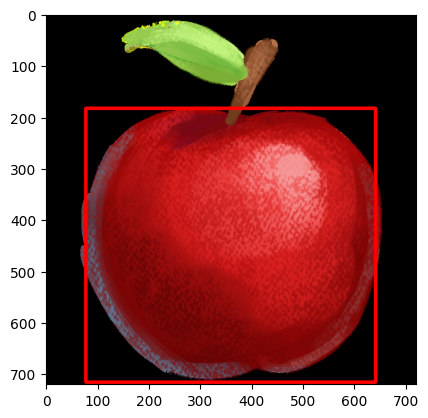

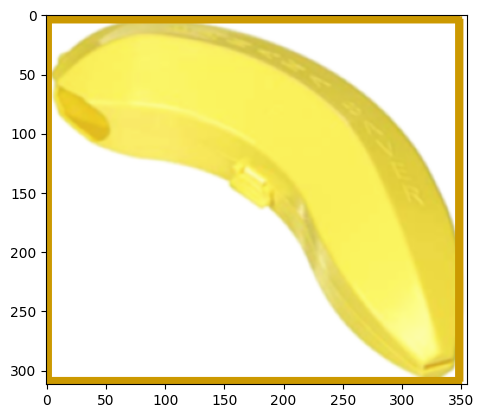

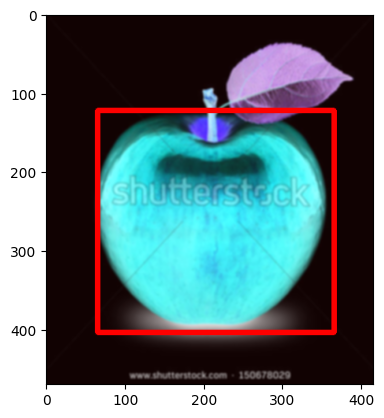

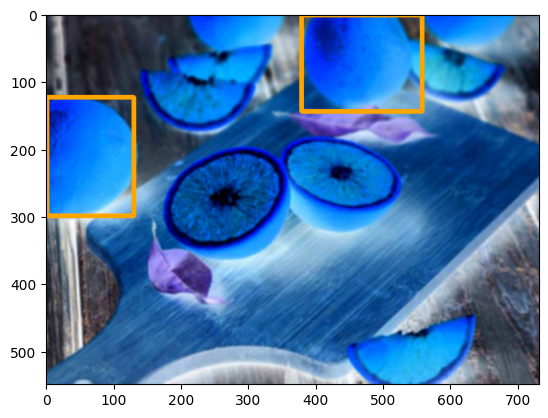

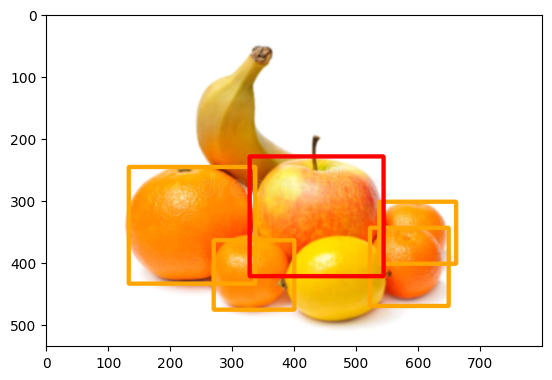

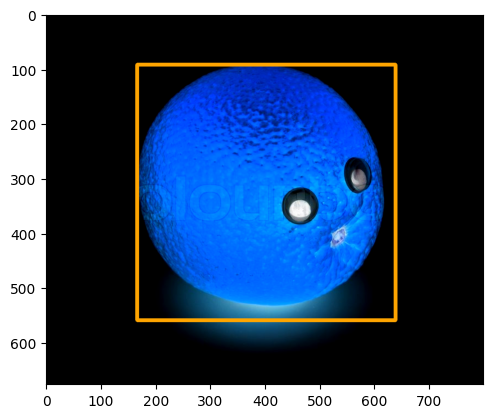

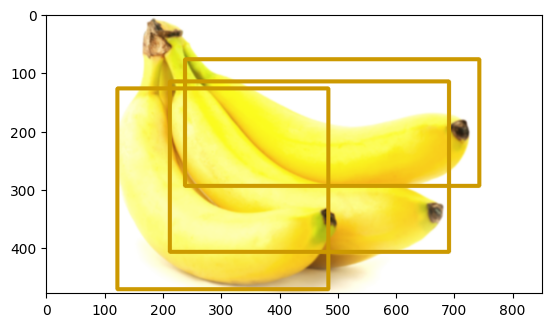

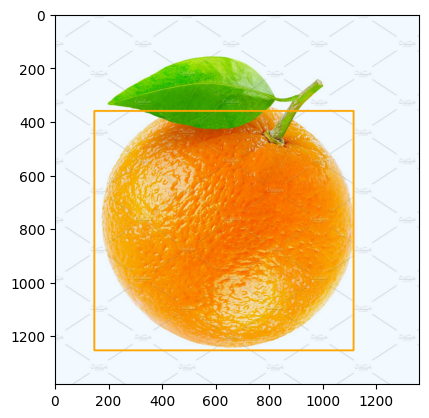

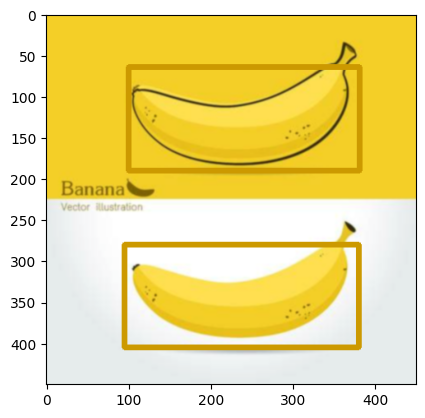

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import cv2
import os

from PIL import Image
from xml.etree import ElementTree as ET
from torchvision.transforms.v2 import Compose, ColorJitter, GaussianBlur, RandomAutocontrast, RandomInvert, ToTensor
import numpy as np
import matplotlib.pyplot as plt


class CustomDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        """
        Properly initialize the dataset. This means filling the lists
        self.images and self.labels with paths to the images and labels, respectively.
        Note: the order of the paths in those lists is important, so use the same order
        (e.g. image orange_90.jpg and label orange_90.xml should be in the same index in the lists).
        """
        self.transform = transform
        # <your_code_here>
        self.root_dir = root_dir
        self.images = []
        self.labels = []

        for file in os.listdir(self.root_dir):
            if file.endswith(".jpg"):
                self.images.append(os.path.join(self.root_dir, file))
                # this is a bit of a hack,
                # it expects that every image has the corresponding xml file of the same name
                self.labels.append(os.path.join(self.root_dir, file.replace(".jpg", ".xml")))
        # </your_code_here>
    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        # <your_code_here>
        return len(self.images)
        # </your_code_here>

    def __getitem__(self, idx):
        """
        Make sure that this method returns a tuple of image and objects where:
        - image is a torch tensor of shape (C, H, W) - [channels, height, width]
        - objects is a list of tuples in the form (xmin, ymin, xmax, ymax, label).
            In other words, each image can contain multiple objects, and each object has
            bounding box data (xmin, ymin, xmax, ymax) and label.
        Note: reading xml files is a bit tricky, feel free to collaborate with your peers
        """
        # <your_code_here>
        image_path = self.images[idx]
        # converting to RGB was needed, because there exist images in RGBA mode
        image = Image.open(image_path).convert('RGB')
    
        # Parse the XML file
        xml_path = self.labels[idx]
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract objects (bounding boxes and labels)
        objects = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            objects.append((xmin, ymin, xmax, ymax, label))
        
        if self.transform:
            image = self.transform(image)
        # </your_code_here>
        return image, objects


"""
Change the custom_transform variable to the transformation you want to apply to the dataset.
Hint: Use torchvision.transformers.v2.Compose to combine multiple transformations.
"""
# </your_code_here>
custom_transform = Compose([
    # Randomly adjusts image brightness and saturation
    # Helps model become robust to different lighting conditions and color variations
    ColorJitter(
        brightness=0.2,
        saturation=0.2,
    ),
    # Randomly applies autocontrast to 50% of images
    # Improves visibility of features
    RandomAutocontrast(p=0.5),
    # Applies Gaussian smoothing with 5x5 kernel
    # Helps reduce noise and makes model more robust to image quality variations
    GaussianBlur(kernel_size=5),
    # Randomly inverts colors in 30% of images
    # Helps model learn features independent of color polarity
    RandomInvert(p=0.3),
    ToTensor(),
])
# </your_code_here>

"""
Change the root_dir variable to the path to the test folder.
"""
# <your_code_here>
root_dir = "dataset/fruit_images/test"
# </your_code_here>

dataset = CustomDataset(
    root_dir=root_dir,
    transform=ToTensor() if custom_transform is None else custom_transform,
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

label_2_colour = {
    "orange": (255, 165, 0),
    "banana": (204, 153, 0),
    "apple": (255, 0, 0),
}

for i, (image, objects) in enumerate(dataloader):
    # image is a tensor of shape (1, 3, H, W)
    # we need to convert it to shape (H, W, 3), and then convert from torch to numpy
    img = image[0].permute(1, 2, 0).numpy()
    # change the img to that it can be displayed with opencv
    img = (img * 255).astype(np.uint8)
    for obj in objects:
        # iterate over the objects and draw bounding boxes around them
        xmin, ymin, xmax, ymax, label = obj
        color = label_2_colour[label[0]]
        img_copy = img.copy()  # Create a copy of the image
        cv2.rectangle(
            img_copy, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 5
        )
        img = img_copy  # Assign the modified copy back to img
    plt.imshow(img)
    plt.show()
    if i == 10:
        break
